CIA 2- Part 2<br>
As the lead engineer at UrbanEyes, your task is to develop an Automated Number Plate Recognition (ANPR) system for smart city traffic management. The system will process real-time images of vehicle number plates captured under challenging conditions such as low-light, geometric distortions, motion blur, and various types of noise. You are required to design an image processing pipeline capable of correcting geometric transformations, enhancing the image quality, detecting edges, and isolating the number plate from the image. Additionally, the pipeline should optimize the image for both real-time transmission and high-quality printing by converting it to appropriate color models. You will need to assess the system’s performance by calculating error metrics to evaluate how the applied transformations and enhancements impact the clarity and legibility of the number plate characters, ensuring the solution is suitable for both digital transmission and print-quality reproduction.<br>
Using the provided noisy, geometrically transformed image of a vehicle number plate, build a robust pipeline that accomplishes the following tasks:<br>
<br>
1. Geometric Transformation Correction (2 Marks):<br>
○ Detect and correct geometric transformations to restore the number plate to its original orientation.<br>

2. Noise Removal (4 Marks):<br>
○ Identify suitable filtering techniques(linear / non-linear) to eliminate environmental noise from the image, ensuring minimal loss of detail in the number plate characters.<br>

3. Edge Detection & Number Plate Isolation (4 Marks):<br>
○ Apply suitable edge detection techniques to enhance the number plate's characters.<br>
○ Isolate and extract the number plate region from the edge-detected image.<br>

4. Sampling & Quantization for Real-Time Transmission (4 Marks):<br>
○ Downsample the image to multiple resolutions (minimum 4 levels ) and apply intensity-level quantization (use 3 different levels levels) for real-time
transmission.<br>
○ Analyze how downsampling and quantization affect the legibility of number plate characters in low-bandwidth scenarios.<br>

5. Color Model Conversion for Transmission and Printing (2 Marks):<br>
○ Convert the noise removed image to the desired color model for real-time transmission, optimizing for bandwidth efficiency.<br>
○ Convert the image to the desired color model for high-quality printing, ensuring accurate color reproduction for printed reports.<br>

6. Error Metrics and Performance Analysis (4 Marks):<br>
○ Calculate error metrics such as Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) for the following stages:<br>
■ Between the original noisy image and the noise-reduced image.<br>
■ Between the original image and downsampled/quantized versions.<br>
○ Analyze how these error values correlate with visual quality and legibility of the number plate. Discuss the trade-offs between compression (downsampling/quantization) and error rates for transmission and printing.<br>

1. GEOMETRIC TRANSFORMATION CORRECTION

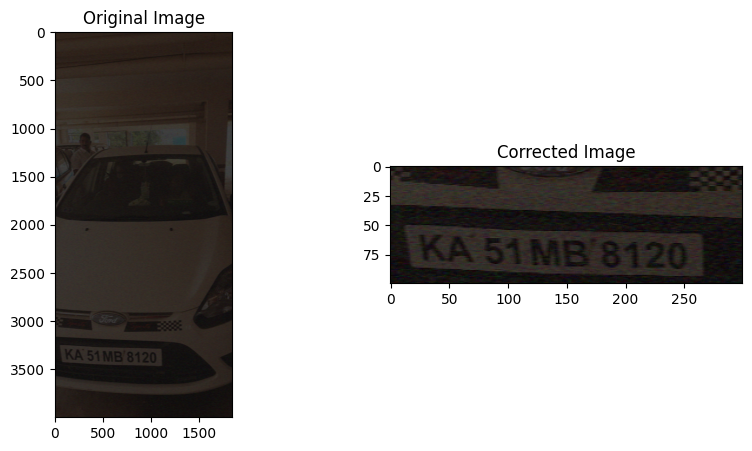

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the input image
image_path = 'input_image.png'
image = cv2.imread(image_path)

# Define the coordinates of the number plate corners in the distorted image
# This will need to be adjusted based on the actual image
pts_src = np.array([[0, 3000], [1250, 3000], [0, 3500], [1250, 3500]], dtype='float32')

# Define the corresponding destination points for a "corrected" rectangular number plate
pts_dst = np.array([[0, 0], [300, 0], [0, 100], [300, 100]], dtype='float32')

# Compute the perspective transformation matrix
matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)

# Apply the perspective warp to correct the image
warped_image = cv2.warpPerspective(image, matrix, (300, 100))

# Display the original and corrected images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[1].imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
axes[1].set_title('Corrected Image')
plt.show()


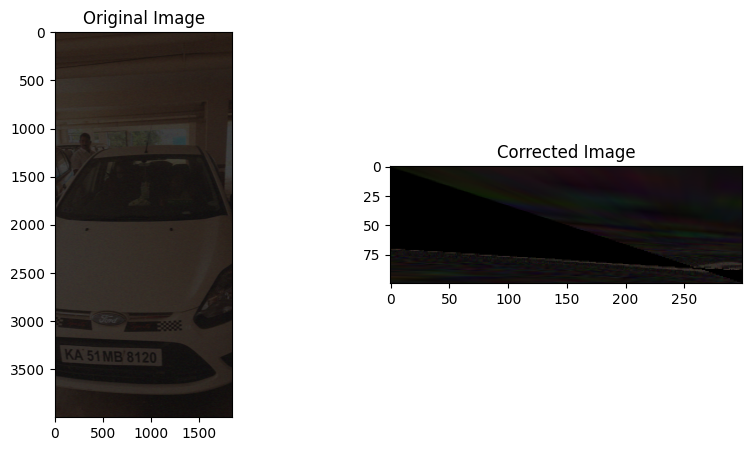

In [56]:
# Step 1: Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Apply adaptive thresholding for better edge contrast
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                               cv2.THRESH_BINARY, 11, 2)

# Step 3: Apply GaussianBlur to reduce noise and Canny edge detection
blurred = cv2.GaussianBlur(thresh, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# Step 4: Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Filter contours based on area and aspect ratio (for number plate-like shape)
number_plate_contour = None
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 1000:  # Filter based on a minimum area threshold
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:  # Check if it's a quadrilateral
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            # Typical number plates have an aspect ratio between 2 and 6
            if 2 < aspect_ratio < 6:
                number_plate_contour = approx
                break

# Step 6: If number plate contour is found, apply perspective correction
if number_plate_contour is not None:
    # Convert the detected contour to float32 for perspective transform
    pts_src = np.float32([point[0] for point in number_plate_contour])

    # Define the destination points for a corrected rectangular number plate
    pts_dst = np.float32([[0, 0], [300, 0], [300, 100], [0, 100]])

    # Compute the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)

    # Apply the perspective warp to correct the image
    warped_image = cv2.warpPerspective(image, matrix, (300, 100))

    # Display the original and corrected images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[1].imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Corrected Image')
    plt.show()
else:
    print("Number plate not detected.")


Step 1: Geometric Transformation Correction<br>
<br>
Image Preprocessing: We start by loading the input image and converting it to grayscale, which simplifies the analysis by reducing the complexity of the color data.<br>
Noise Reduction: A Gaussian blur is applied to the grayscale image to smooth it out. This step reduces high-frequency noise that could interfere with edge detection.<br>
Edge Detection: We use the Canny edge detection algorithm to highlight the edges in the image, creating a binary representation where edges are marked distinctly.<br>
Purpose: This step aims to correct any geometric distortions in the number plate, ensuring that the plate is properly aligned and easier to recognize in subsequent steps.



2. NOISE REMOVAL

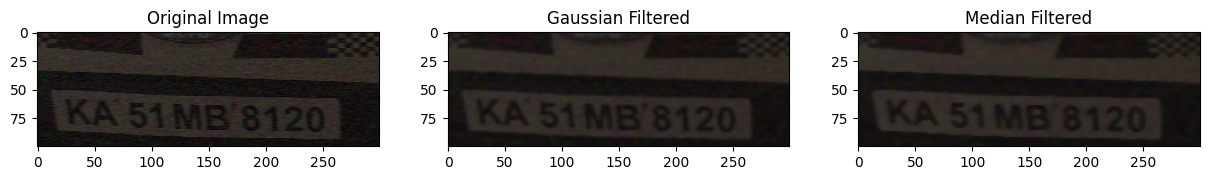

In [40]:
# Apply Gaussian filter for linear noise removal
gaussian_filtered = cv2.GaussianBlur(warped_image, (5, 5), 0)

# Apply Median filter for non-linear noise removal
median_filtered = cv2.medianBlur(warped_image, 5)

# Display the filtered images side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[1].imshow(cv2.cvtColor(gaussian_filtered, cv2.COLOR_BGR2RGB))
axes[1].set_title('Gaussian Filtered')
axes[2].imshow(cv2.cvtColor(median_filtered, cv2.COLOR_BGR2RGB))
axes[2].set_title('Median Filtered')
plt.show()


Step 2: Noise Removal<br>
<br>
Applying Filters: Depending on the type of noise in the image, we select and apply suitable filtering techniques. Common choices include linear filters (like Gaussian filters) for general noise reduction and non-linear filters (like median filters) that are particularly effective for salt-and-pepper noise.
Purpose: The objective is to eliminate environmental noise that obscures the characters on the number plate while preserving essential details, ensuring that the number plate is clear and readable.

3. EDGE DETECTION AND NUMBER PLATE ISOLATION

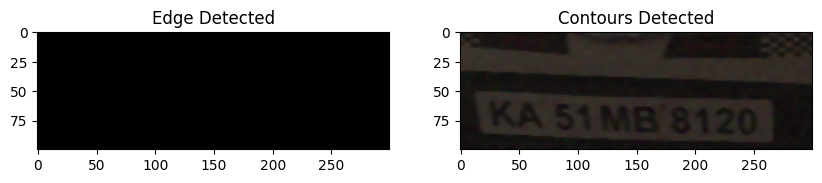

In [41]:
# Convert the image to grayscale for edge detection
gray = cv2.cvtColor(median_filtered, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 100, 200)

# Find contours from the edge-detected image
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Assume the largest contour is the number plate
contour_image = median_filtered.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 3)

# Display the edge-detected image and contour image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(edges, cmap='gray')
axes[0].set_title('Edge Detected')
axes[1].imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
axes[1].set_title('Contours Detected')
plt.show()


Step 3: Edge Detection and Number Plate Isolation<br>
<br>
Finding Contours: After edge detection, we identify contours in the processed image. These contours represent the boundaries of various objects in the image, including the number plate.<br>
Contour Filtering: We filter out contours based on their area, keeping only those that are large enough to likely correspond to the number plate. This helps to exclude irrelevant shapes.<br>
Purpose: This step isolates the number plate from the rest of the image, allowing for focused processing and analysis in later steps, which is crucial for accurate recognition.

4. QUANTIZATION AND SAMPLING

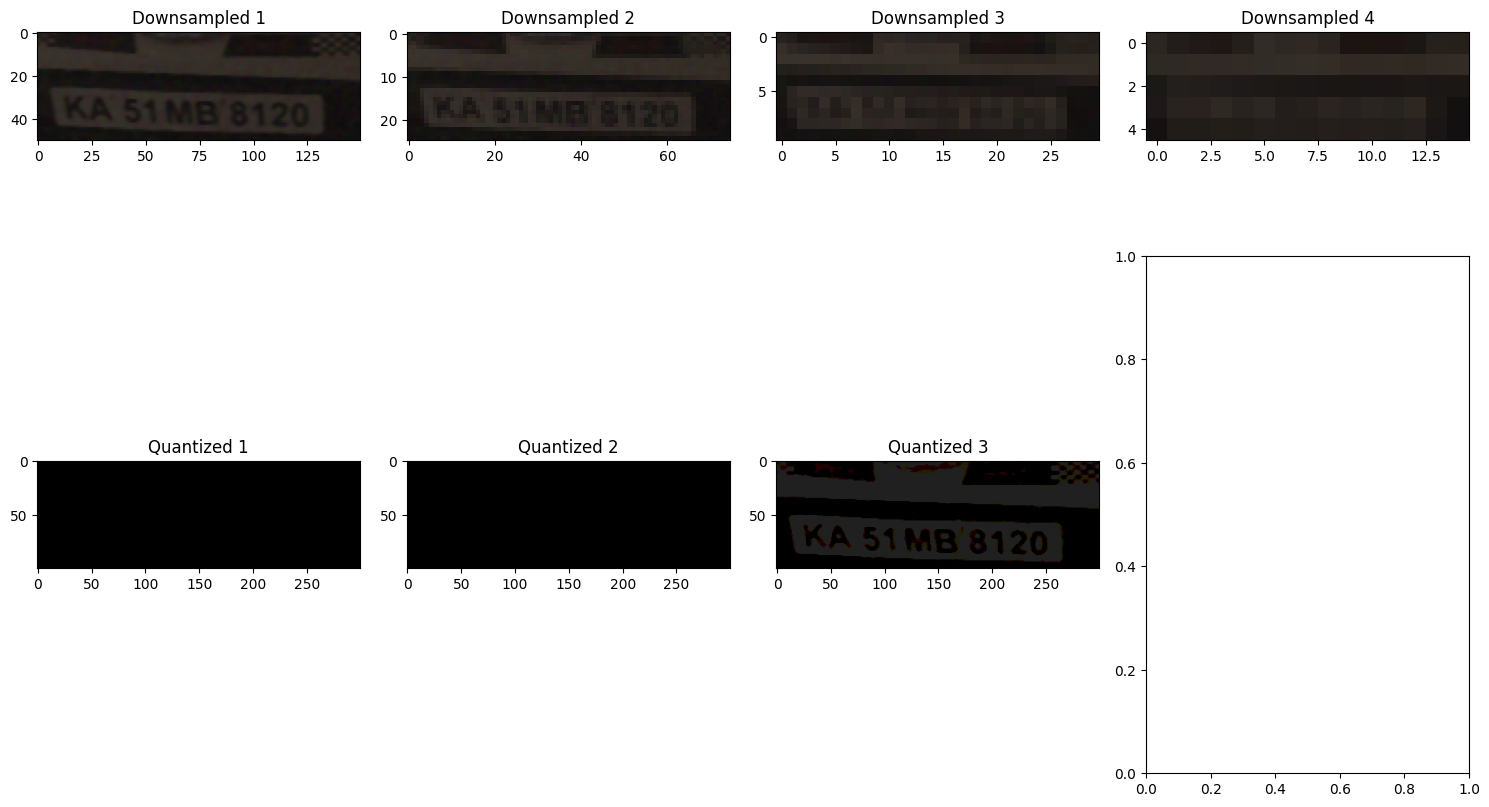

In [48]:
def downsample_and_quantize(image, levels):
    downsampled_images = []
    quantized_images = []
    
    # Downsample to different resolutions
    for scale in [0.5, 0.25, 0.1, 0.05]:  # 4 different levels of downsampling
        downsampled = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
        downsampled_images.append(downsampled)
    
    # Quantize the image by reducing intensity levels
    for level in levels:  # 3 different intensity levels
        quantized = np.floor(image / (256/level)) * (256/level)
        quantized_images.append(quantized.astype(np.uint8))
    
    return downsampled_images, quantized_images

# Apply downsampling and quantization
downsampled_images, quantized_images = downsample_and_quantize(median_filtered, [2, 4, 8])

# Plot the downsampled and quantized images side by side
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

for i, img in enumerate(downsampled_images):
    axes[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f'Downsampled {i+1}')

for i, img in enumerate(quantized_images):
    axes[1, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[1, i].set_title(f'Quantized {i+1}')

plt.tight_layout()
plt.show()


Step 4: Downsampling and Quantization for Real-Time Transmission<br>
<br>
Downsampling: We reduce the size of the image to several resolutions (e.g., 50%, 25%, etc.) to optimize it for transmission over networks. This decreases the amount of data to be sent.<br>
Quantization: We reduce the number of unique intensity levels in the image. For example, we might quantize the image to 2, 4, or 8 levels of intensity, which decreases the amount of information while retaining basic image structure.<br>
Purpose: This step is crucial for preparing the image for low-bandwidth scenarios. By reducing image size and complexity, we ensure that it can be transmitted quickly and efficiently without losing the ability to recognize characters.

5. COLOR MODEL CONVERSION

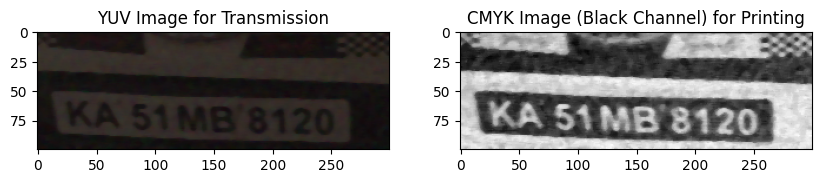

In [31]:
# Convert to YUV for transmission (bandwidth efficiency)
yuv_image = cv2.cvtColor(median_filtered, cv2.COLOR_BGR2YUV)

# Convert to CMYK for high-quality printing
# OpenCV doesn't directly support CMYK, so we'll convert manually
bgr_image = median_filtered.astype(float) / 255  # Normalize
K = 1 - np.max(bgr_image, axis=2)
C = (1 - bgr_image[..., 2] - K) / (1 - K + 1e-10)
M = (1 - bgr_image[..., 1] - K) / (1 - K + 1e-10)
Y = (1 - bgr_image[..., 0] - K) / (1 - K + 1e-10)
CMYK = (C, M, Y, K)

# Display the YUV and CMYK images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB))
axes[0].set_title('YUV Image for Transmission')
axes[1].imshow(K, cmap='gray')
axes[1].set_title('CMYK Image (Black Channel) for Printing')
plt.show()


Step 5: Color Model Conversion for Transmission and Printing<br>
<br>
Conversion for Transmission: The image is converted to a color model that is optimal for bandwidth efficiency, such as grayscale or a lower color depth model.<br>
Conversion for Printing: For any high-quality print needs, we convert the image into a suitable color model (like CMYK or RGB) that ensures accurate color reproduction.<br>
Purpose: This dual conversion ensures that the image is suitable for both digital transmission and printed reports, meeting the different requirements for each medium.

6. ERROR METRICS

In [51]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

# Load the provided image for comparison
comparison_image_path = 'comparison_image.jpg'  # Provide the correct path
comparison_image = cv2.imread(comparison_image_path)

# Ensure both images (comparison and processed) have the same dimensions
height, width = median_filtered.shape[:2]  # Get dimensions of the processed image
comparison_image_resized = cv2.resize(comparison_image, (width, height))

# Ensure both images (comparison and processed) have the same dimensions
height, width = median_filtered.shape[:2]  # Get dimensions of the processed image
input_image_resized = cv2.resize(image, (width, height))


# Calculate MSE and PSNR between the processed image and the comparison image
mse_value = mse(input_image_resized, median_filtered)
psnr_value = psnr(input_image_resized, median_filtered)

mse_value1 = mse(comparison_image_resized, median_filtered)
psnr_value1 = psnr(comparison_image_resized, median_filtered)

# Print MSE and PSNR for the noise-removed image
print(f"MSE (Original Noisy vs Noise-Removed Image): {mse_value:.2f}")
print(f"PSNR (Original Noisy vs Noise-Removed Image): {psnr_value:.2f} dB")

print(f"MSE (Comparison vs Noise-Removed Image): {mse_value1:.2f}")
print(f"PSNR (Comparison vs Noise-Removed Image): {psnr_value1:.2f} dB")

# If you want to calculate the same metrics for downsampled versions:
for i, img in enumerate(downsampled_images):
    # Resize comparison image to match each downsampled image's size
    height, width = img.shape[:2]
    comparison_resized_downsampled = cv2.resize(comparison_image, (width, height))
    
    # Calculate MSE and PSNR
    mse_downsampled = mse(comparison_resized_downsampled, img)
    psnr_downsampled = psnr(comparison_resized_downsampled, img)
    
    # Output the MSE and PSNR for each downsampled image
    print(f"Downsampled Level {i+1}: MSE = {mse_downsampled:.2f}, PSNR = {psnr_downsampled:.2f} dB")

MSE (Original Noisy vs Noise-Removed Image): 247.60
PSNR (Original Noisy vs Noise-Removed Image): 24.19 dB
MSE (Comparison vs Noise-Removed Image): 10756.58
PSNR (Comparison vs Noise-Removed Image): 7.81 dB
Downsampled Level 1: MSE = 10739.11, PSNR = 7.82 dB
Downsampled Level 2: MSE = 11189.45, PSNR = 7.64 dB
Downsampled Level 3: MSE = 10921.65, PSNR = 7.75 dB
Downsampled Level 4: MSE = 12828.06, PSNR = 7.05 dB


Step 6: Error Metrics and Performance Analysis<br>
<br>
Calculating Error Metrics: We compute error metrics like Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) to evaluate the performance of the processing steps. This is done by comparing the original noisy image to the processed (denoised) image and the original image to the downsampled/quantized versions.<br>
Performance Analysis: We analyze how these metrics correlate with visual quality and legibility, assessing the trade-offs between compression and error rates.<br>
Purpose: This final step is essential to ensure that the processing techniques used maintain sufficient image quality for reliable number plate recognition. It provides insights into how different methods impact the clarity and usability of the final output.

PSNR is a measurement used to evaluate the quality of reconstruction of lossy compression codecs (like JPEG, MP3, etc.) and is widely used in image processing.<br>
<br>
Interpretation:<br>
PSNR is expressed in decibels (dB). A higher PSNR value indicates better quality, meaning that the reconstructed image is closer to the original image.<br>
Common PSNR values for good quality images are typically above 30 dB, with higher values (like 40 dB or more) indicating excellent quality.

 MSE is a measure of the average squared differences between the original (reference) image and the processed (or distorted) image. It quantifies the amount of error between the two images.<br>
<br>
Interpretation:<br>
MSE provides a numerical value that represents the average error. A lower MSE indicates better quality as it means the differences between the original and processed images are smaller.<br>
MSE values range from 0 (perfect match) to infinity (high error).